In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
import datetime
import seaborn as sns
import matplotlib
from matplotlib import colors
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
np.random.seed(42)

data = pd.read_csv("/Users/shistatabagale/Downloads/Project_Final/marketing_campaign.csv", sep="\t")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

# Data Cleaning and Preparation


In [2]:
import datetime

# Changing the Dt_customer to date format
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'], format='%d-%m-%Y')

missing_values_in_income = data[data['Income'].isna()]
#print(missing_values_in_income)



# data['Income'] = data['Income'].fillna(data['Income'].mean())
data['Income'] = data['Income'].dropna()
data = data.dropna()
data.shape

(2216, 29)

# Feature engineering



In [3]:
## Adding Age column of the customer
data['Age'] = 2024-data['Year_Birth']

## #For clarity
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})


# Marital status
data['Marital_Status']= data['Marital_Status'].replace({'Alone':'Single','YOLO':'Single','Absurd':'Single'})
data["Marital_Status"] = data["Marital_Status"].replace({"Married":"Together", "Widow":"Single", "Divorced":"Single"})


# Number of kids 
data["Kids"]=data["Kidhome"]+data["Teenhome"]

## Creating Family Size out of number of kids and Marital_status
data["Family_Size"] = data["Marital_Status"].replace({"Single": 1, "Together":2})+ data["Kids"]

### Calculate the total expenses by summing the relevant columns
data['Total_Expenses'] = data['Wines'] + data['Fruits'] + data['Meat'] + data['Fish'] + data['Sweets'] + data['Gold']

#Dropping some of the redundant features
to_drop = ["Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

## Dropping the outliers from age and income 
data = data[(data["Age"]<80)]
data = data[(data["Income"]<150000)]
data.drop_duplicates(inplace=True)
data.shape


(2006, 28)

# Exploratory Data Analysis

In [4]:
data.describe()

Income      Kidhome     Teenhome      Recency        Wines  \
count    2006.000000  2006.000000  2006.000000  2006.000000  2006.000000   
mean    51590.022433     0.446162     0.512961    48.861914   304.355932   
std     20714.335770     0.536770     0.546657    28.950907   336.551185   
min      1730.000000     0.000000     0.000000     0.000000     0.000000   
25%     35265.000000     0.000000     0.000000    24.000000    23.250000   
50%     51371.000000     0.000000     0.000000    49.000000   175.500000   
75%     68138.000000     1.000000     1.000000    74.000000   504.750000   
max    113734.000000     2.000000     2.000000    99.000000  1493.000000   

            Fruits         Meat         Fish       Sweets         Gold  ...  \
count  2006.000000  2006.000000  2006.000000  2006.000000  2006.000000  ...   
mean     26.260219   165.261216    37.350449    27.280160    44.093220  ...   
std      39.710236   219.610064    54.695961    41.596078    51.823139  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       2.000000    16.000000     3.000000     1.000000     9.000000  ...   
50%       8.000000    67.500000    12.000000     8.000000    25.000000  ...   
75%      33.000000   229.250000    49.750000    34.000000    57.000000  ...   
max     199.000000  1725.000000   259.000000   262.000000   321.000000  ...   

       AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2     Complain  \
count   2006.000000   2006.000000   2006.000000   2006.000000  2006.000000   
mean       0.076271      0.071286      0.065304      0.012961     0.008973   
std        0.265498      0.257366      0.247123      0.113135     0.094324   
min        0.000000      0.000000      0.000000      0.000000     0.000000   
25%        0.000000      0.000000      0.000000      0.000000     0.000000   
50%        0.000000      0.000000      0.000000      0.000000     0.000000   
75%        0.000000      0.000000      0.000000      0.000000     0.000000   
max        1.000000      1.000000      1.000000      1.000000     1.000000   

          Response          Age         Kids  Family_Size  Total_Expenses  
count  2006.000000  2006.000000  2006.000000  2006.000000     2006.000000  
mean      0.153539    54.939681     0.959123     2.600698      604.601196  
std       0.360597    11.509807     0.744271     0.903625      601.409868  
min       0.000000    28.000000     0.000000     1.000000        5.000000  
25%       0.000000    47.000000     0.000000     2.000000       69.000000  
50%       0.000000    54.000000     1.000000     3.000000      396.000000  
75%       0.000000    64.000000     1.000000     3.000000     1043.750000  
max       1.000000    79.000000     3.000000     5.000000     2525.000000  

[8 rows x 26 columns]

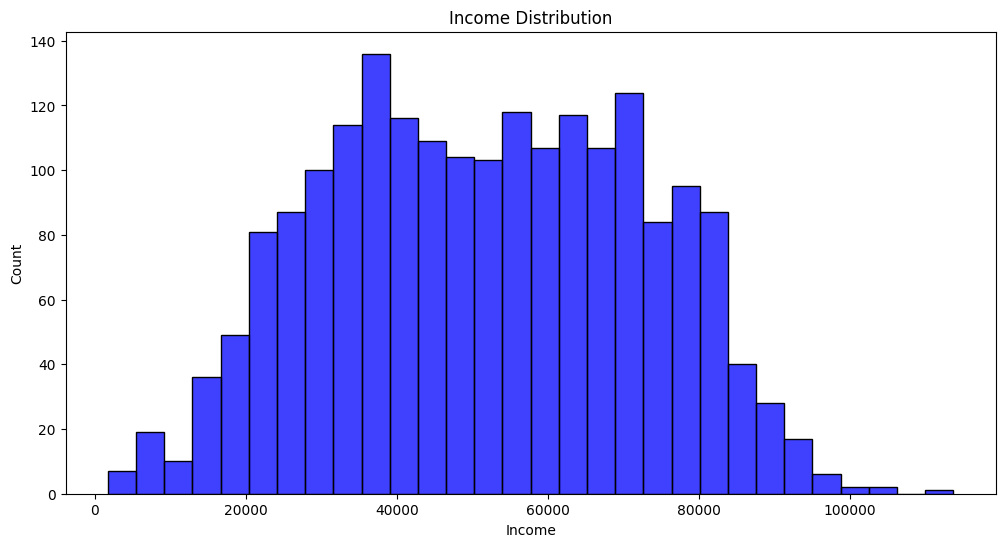

In [5]:
# Plot of age after removing outliers

# Age distribution
# #Create a new variable 'Age_group' to form groups of customers by age
# bins=[30,40,50,60,70,80,90]
# labels = ['20-30','30-40','40-50','50-60','70-80','80+']

# data['Age_group'] = pd.cut(data['Age'],bins=bins,labels=labels)
# plt.figure(figsize=(8,8))
# plt.title('Age distribution after outlier removal')
# sns.histplot(data['Age_group'])
# plt.savefig('/Users/shistatabagale/Downloads/Project_Final/Figure/AGE.png')
# plt.show()


#Plot of income after removing outliers

plt.figure(figsize=(12, 6))
sns.histplot(data['Income'], bins=30, color='blue', edgecolor='black')
plt.title('Income Distribution')
plt.xlabel('Income')
plt.ylabel('Count')
plt.savefig('/Users/shistatabagale/Downloads/Project_Final/Figure/INCOME.png')
plt.show()




Wines     610538
Fruits     52678
Meat      331514
Fish       74925
Sweets     54724
Gold       88451
dtype: int64
The product category with the highest total spending is: Wines
Total spending in this category: 610538


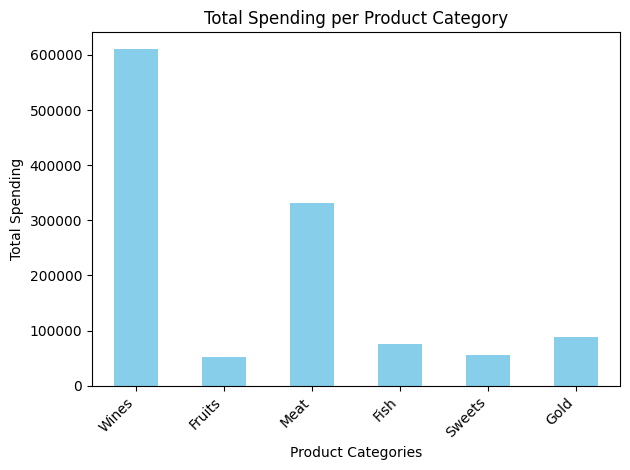

In [6]:
# List of product columns
product_columns = ['Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold']

# Sum the spending for each product category
total_spending_per_category = data[product_columns].sum()

# Print the total spending per category
print(total_spending_per_category)

# Find the product category with the highest total spending
highest_spending_category = total_spending_per_category.idxmax()
highest_spending_amount = total_spending_per_category.max()

print(f"The product category with the highest total spending is: {highest_spending_category}")
print(f"Total spending in this category: {highest_spending_amount}")

# Plot total spending per category
total_spending_per_category.plot(kind='bar', color='skyblue', title='Total Spending per Product Category')

# Label the chart
plt.xlabel('Product Categories')
plt.ylabel('Total Spending')
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()

# plt.savefig('/Users/shistatabagale/Downloads/Project_Final/Figure/Total_expenses_category.png')
plt.show()

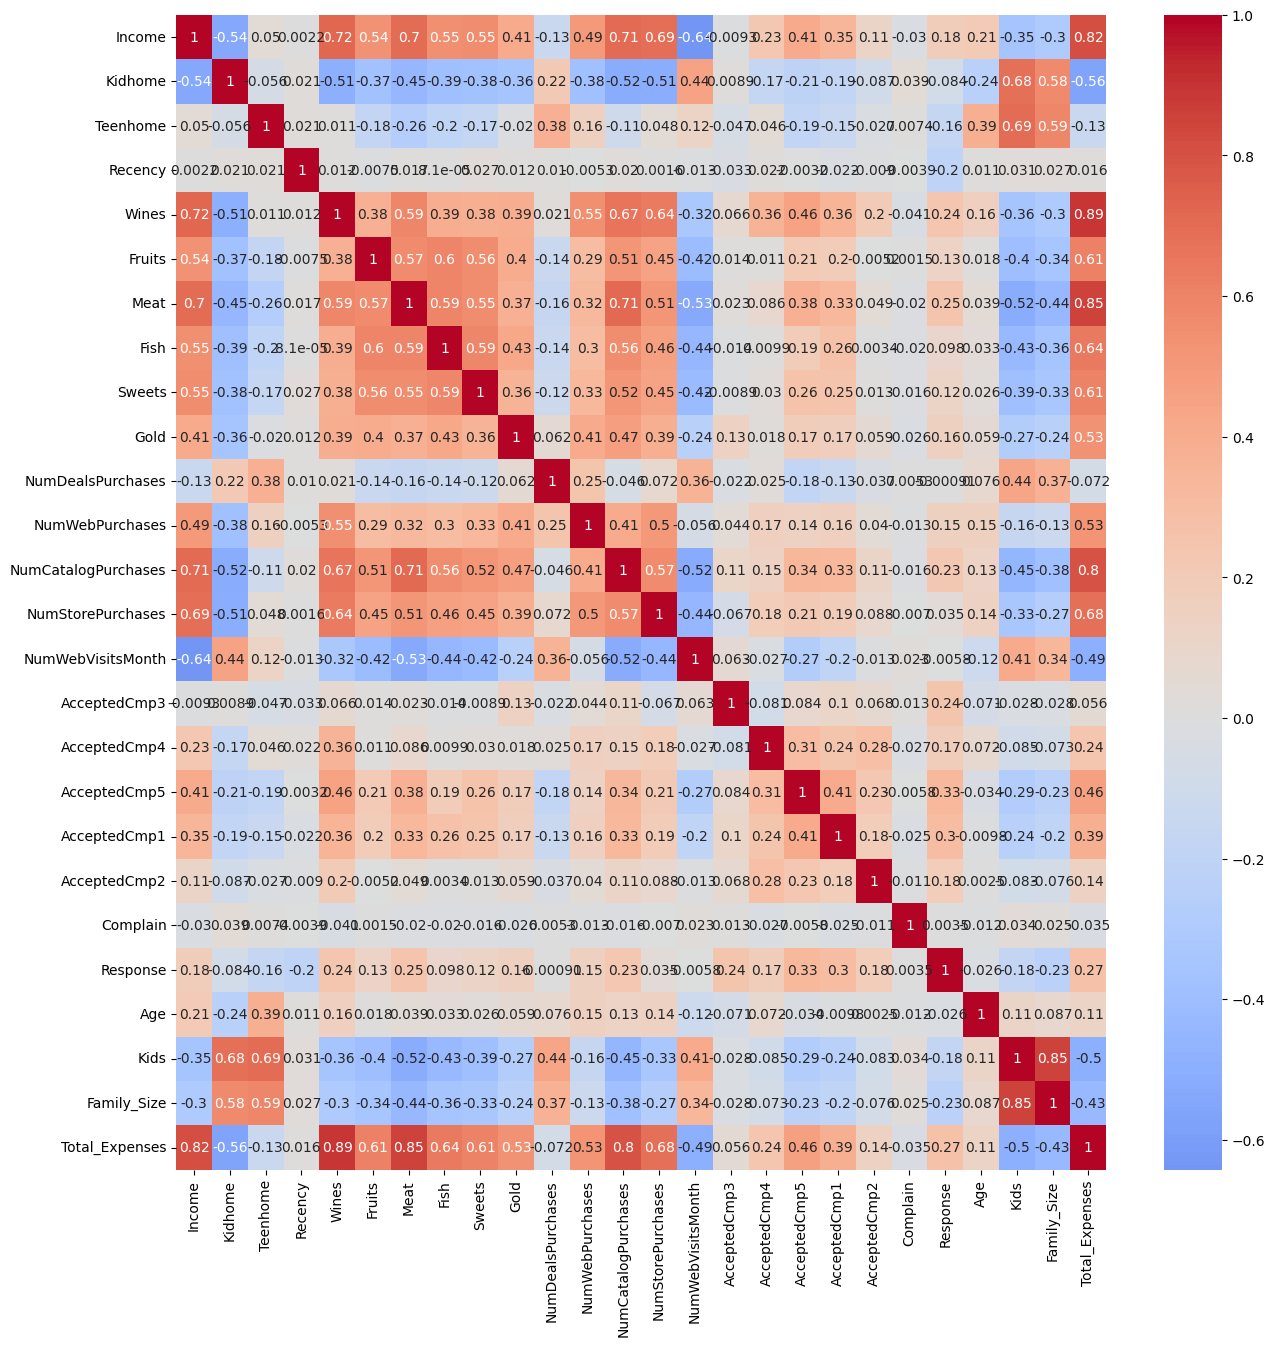

In [7]:
## Correlation among the variables

numeric_df = data.select_dtypes(include=['int64', 'float64'])
#print(numeric_df.columns)

from matplotlib import colors
corrmat= numeric_df.corr()
plt.figure(figsize=(15, 15))  
sns.heatmap(corrmat,annot=True, cmap='coolwarm', center=0)
plt.savefig('/Users/shistatabagale/Downloads/Project_Final/Figure/Correlation.png')


# Data Preprocessing

In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

data.drop_duplicates(inplace=True)
data.head(3)


Education Marital_Status   Income  Kidhome  Teenhome  Recency  Wines  \
0  Graduation         Single  58138.0        0         0       58    635   
1  Graduation         Single  46344.0        1         1       38     11   
2  Graduation       Together  71613.0        0         0       26    426   

   Fruits  Meat  Fish  ...  AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  \
0      88   546   172  ...             0             0             0   
1       1     6     2  ...             0             0             0   
2      49   127   111  ...             0             0             0   

   AcceptedCmp2  Complain  Response  Age  Kids  Family_Size  Total_Expenses  
0             0         0         1   67     0            1            1617  
1             0         0         0   70     2            3              27  
2             0         0         0   59     0            2             776  

[3 rows x 28 columns]

In [9]:
# Handling categorical variables

#Get list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Marital_Status']


In [10]:
#Label Encoding the object dtypes.
LE=LabelEncoder()
for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform)
    
print("All features are now numerical")

All features are now numerical


In [11]:
data.head(2)

Education  Marital_Status   Income  Kidhome  Teenhome  Recency  Wines  \
0          2               0  58138.0        0         0       58    635   
1          2               0  46344.0        1         1       38     11   

   Fruits  Meat  Fish  ...  AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  \
0      88   546   172  ...             0             0             0   
1       1     6     2  ...             0             0             0   

   AcceptedCmp2  Complain  Response  Age  Kids  Family_Size  Total_Expenses  
0             0         0         1   67     0            1            1617  
1             0         0         0   70     2            3              27  

[2 rows x 28 columns]

In [12]:
ds = data.copy()

In [13]:
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)

# #Scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

All features are now scaled


In [14]:
scaled_ds.shape

(2006, 21)

In [ ]:


# # Perform PCA
# pca = PCA()
# pca.fit(scaled_ds)

# # Explained variance for each component
# explained_variance = pca.explained_variance_ratio_

# explained_variance_ratio = pca.explained_variance_ratio_

# # Create a DataFrame to display the variance explained by each PC
# explained_variance_df = pd.DataFrame({
#     'Principal Component': [f'PC{i+1}' for i in range(len(explained_variance_ratio))],
#     'Variance Explained (%)': explained_variance_ratio * 100
# })

# # Display the table
# # print(explained_variance_df)

# import numpy as np
# import pandas as pd

# 
# # Create a DataFrame 
# df = pd.DataFrame({
#     'Principal Component': ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 
#                             'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'PC21'],
#     'Variance Explained (%)': [37.75656, 12.77552, 6.79010, 6.21439, 5.08936, 4.78918, 4.37937, 3.18453, 2.95058, 2.79348,
#                                2.47322, 2.11061, 2.03258, 1.84410, 1.72222, 1.27132, 1.12663, 0.69626, 5.49489e-14, 0.0, 0.0]
# })

# # Calculate cumulative variance explained
# df['Cumulative Variance Explained (%)'] = np.cumsum(df['Variance Explained (%)'])

# # Display the table with cumulative variance
# print(df)



# # Cumulative explained variance
# cumulative_variance = np.cumsum(explained_variance)

# # Plot individual explained variance
# plt.figure(figsize=(8, 6))
# plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, label='Explained Variance')
# plt.xlabel('Principal Component')
# plt.ylabel('Explained Variance Ratio')
# plt.title('Explained Variance for Each Principal Component')
# plt.show()

# # Plot cumulative explained variance
# plt.figure(figsize=(8, 6))
# plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='blue', linestyle='--', label='Cumulative Explained Variance')
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.title('Cumulative Explained Variance')

# plt.savefig('/Users/shistatabagale/Downloads/Project_Final/Figure/PCA_cusum.png')

# plt.show()

# Print explained variance for each component and cumulative variance
# print("Explained Variance Ratio:", explained_variance)
# print("Cumulative Explained Variance:", cumulative_variance)


In [16]:

# scaled_ds.head(2)

# pca = PCA(n_components=3)
# pca.fit(scaled_ds)
# PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["PCA1","PCA2"]))
# PCA_ds.describe().T

# # 3D visualization of the PCA components
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d')
# # Scatter plot
# ax.scatter(PCA_ds["PCA1"], PCA_ds["PCA2"], c='blue', alpha=0.7)

# # Labels and title
# ax.set_title("3D Visualization of PCA Components")
# ax.set_xlabel("PCA1")
# ax.set_ylabel("PCA2")


# # plt.savefig('/Users/shistatabagale/Downloads/Project_Final/Figure/PCA_3D.png')

# plt.show()

In [17]:
# # Dimensionality Reduction Using n=10

# scaled_ds.head(2)

# pca = PCA(n_components=10)
# pca.fit(scaled_ds)
# pca_df = pd.DataFrame(pca.transform(scaled_ds), columns=(["PC1","PC2", "PC3","PC4","PC5","PC6", "PC7","PC8","PC9", "PC10"]))
# pca_df.describe().T

# plt.figure(figsize=(8, 6))
# plt.scatter(pca_df['PC1'], pca_df['PC2'], c='blue', alpha=0.5)
# plt.title('PCA Reduced Data (First 2 PCs)')
# plt.xlabel('PC1')
# plt.ylabel('PC2')
# plt.grid(True)
# plt.show()

# # 3D visualization of the PCA components
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d')
# # Scatter plot
# ax.scatter(pca_df["PC1"], pca_df["PC2"], pca_df["PC3"], c='blue', alpha=0.7)

# # Labels and title
# ax.set_title("3D Visualization of PCA Components")
# ax.set_xlabel("PC1")
# ax.set_ylabel("PC2")
# ax.set_zlabel("PC3")

# # plt.savefig('/Users/shistatabagale/Downloads/Project_Final/Figure/PCA_3D.png')

# plt.show()

In [18]:
# # Optimal number of clusters using elbow method

# from yellowbrick.cluster import KElbowVisualizer

# Elbow_M = KElbowVisualizer(KMeans(), k=10)
# Elbow_M.fit(pca_df)

# # plt.savefig('/Users/shistatabagale/Downloads/Project_Final/Figure/ELBOW.png')
# Elbow_M.show()

In [19]:
# import matplotlib.pyplot as plt
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score

# # List to store silhouette scores for each k value
# sil_scores = []

# # Calculate silhouette score for each k (from 2 to 19)
# for k in range(2, 20):
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     kmeans.fit(pca_df)  
#     score = silhouette_score(pca_df, kmeans.labels_)
#     sil_scores.append(score)

# # Plot silhouette scores
# plt.figure(figsize=(8, 6))
# plt.plot(range(2, 20), sil_scores, marker='o', color='b')  # Updated range
# plt.title('Silhouette Scores for Optimal K')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Silhouette Score')
# plt.xticks(range(2, 20))  # Optional: Adjust x-axis ticks for better visualization

# plt.show()


In [21]:
# # Create 2D scatter plot for K-Means clustering with 2 clusters
# fig, ax = plt.subplots(figsize=(10,10))

# # Scatter plot for K-Means clustering using first two PCA components
# s_2d = ax.scatter(pdf.iloc[:, 0], pdf.iloc[:, 1], c=pca_df['Cluster__kMeans_3'], cmap='viridis')

# legend_labels = ['Cluster 0', 'Cluster 1','Cluster3']  
# handles = [mpatches.Patch(color=s_2d.cmap(s_2d.norm(i)), label=label) 
#            for i, label in enumerate(legend_labels)]
# ax.legend(handles=handles, title='Cluster')

# # Set the title and axis labels
# ax.set_title('K-Means Clustering with 4 Clusters (2D)')
# ax.set_xlabel('PCA Component 1')
# ax.set_ylabel('PCA Component 2')

# # Add color bar to indicate cluster assignments
# fig.colorbar(scatter_2d, label='Cluster')

# # plt.savefig('/Users/shistatabagale/Downloads/Project_Final/Figure/k-means2_2D.png')
# plt.show()

In [22]:
# print(pca_df.head(2))

In [23]:
# from sklearn.metrics import silhouette_score

# # Extract the feature columns (PCA1, PCA2, PCA3)
# X = pca_df[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6','PC7', 'PC8', 'PC9', 'PC10']]

# # List of clustering columns to evaluate
# clustering_columns = ['Cluster_kMeans_2', 'Cluster__kMeans_4', 'Cluster__kMeans_3']

# # Initialize variables to track the best clustering
# best_score = -1  # Silhouette score can be between -1 and 1, so we start with a low value
# best_clustering = ""
# # Calculate silhouette score for each clustering result
# for clustering_column in clustering_columns:
#     cluster_labels = pca_df[clustering_column]
#     score = silhouette_score(X, cluster_labels)
#     print(f"Silhouette score for {clustering_column}: {score}")

#     if score > best_score:
#         best_score = score
#         best_clustering = clustering_column

# print(f"The best clustering is: {best_clustering} with a silhouette score of {best_score:.4f}")

In [24]:

# pl = sns.scatterplot(data = data,x=data["Total_Expenses"], y=data["Income"],hue=pca_df["Cluster__kMeans_4"], palette='viridis')
# pl.set_title("Cluster's Profile Based On Income And Spending")
# plt.legend()
# plt.show()

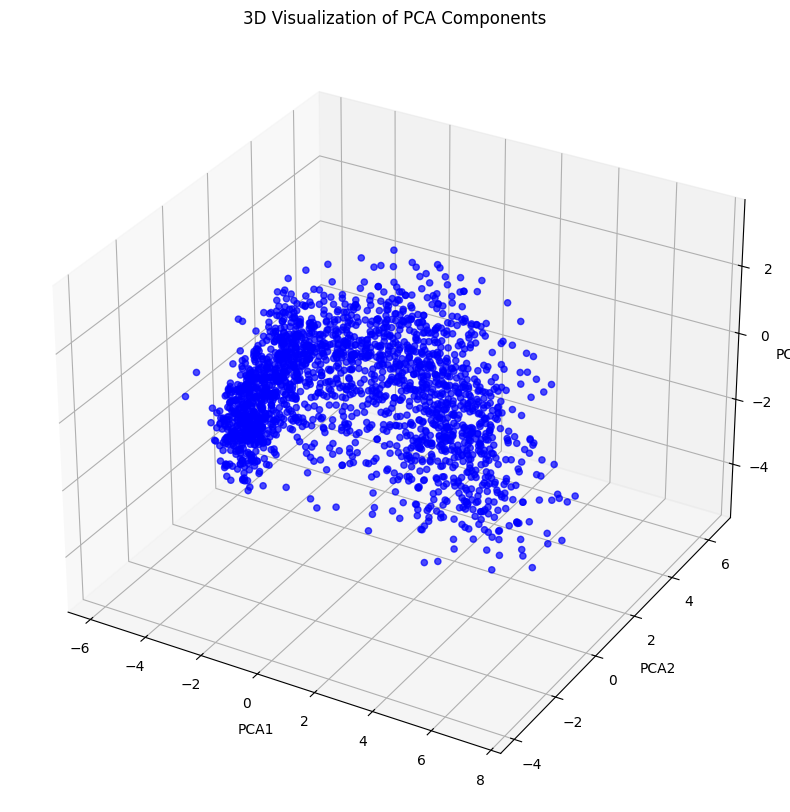

In [25]:
# Dimensionality Reduction

scaled_ds.head(2)

pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["PCA1","PCA2", "PCA3"]))
PCA_ds.describe().T

# 3D visualization of the PCA components
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# Scatter plot
ax.scatter(PCA_ds["PCA1"], PCA_ds["PCA2"], PCA_ds["PCA3"], c='blue', alpha=0.7)

# Labels and title
ax.set_title("3D Visualization of PCA Components")
ax.set_xlabel("PCA1")
ax.set_ylabel("PCA2")
ax.set_zlabel("PCA3")

# plt.savefig('/Users/shistatabagale/Downloads/Project_Final/Figure/PCA_3D.png')

plt.show()


In [26]:
# Loadings for the first three principal components
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3'], index=scaled_ds.columns)
# Display the loadings
print(loadings)

                          PC1       PC2       PC3
Education            0.008368  0.157699  0.464375
Marital_Status      -0.027108  0.150831 -0.397733
Income               0.300118  0.158760  0.054003
Kidhome             -0.249825  0.013028 -0.297747
Teenhome            -0.078567  0.492187  0.140671
Recency              0.001346  0.025671 -0.054309
Wines                0.269431  0.192552  0.122760
Fruits               0.246192 -0.030187 -0.241218
Meat                 0.293765 -0.029428 -0.082149
Fish                 0.255775 -0.035428 -0.253261
Sweets               0.245398 -0.016964 -0.245994
Gold                 0.200006  0.099737 -0.175609
NumDealsPurchases   -0.070129  0.372257 -0.146957
NumWebPurchases      0.184295  0.281263  0.000793
NumCatalogPurchases  0.293559  0.077774 -0.019428
NumStorePurchases    0.258506  0.180373  0.008912
NumWebVisitsMonth   -0.225340  0.071608 -0.060912
Age                  0.042858  0.276219  0.381302
Kids                -0.237881  0.370901 -0.111415



# K Mean Clusturing

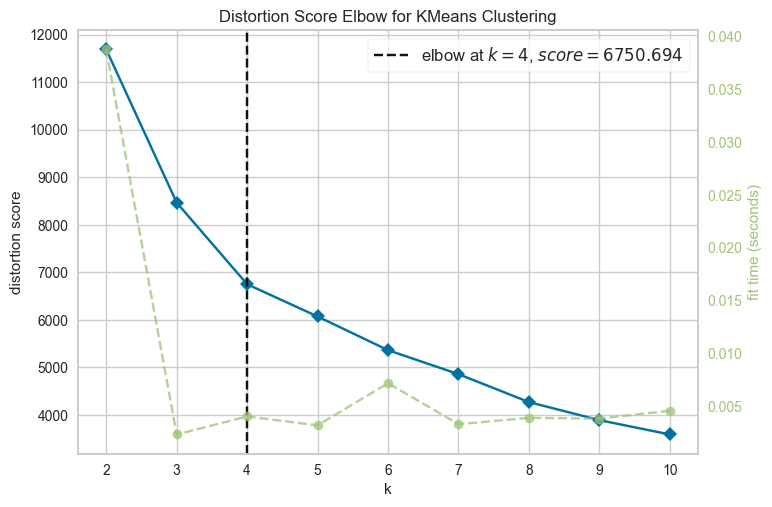

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [27]:
# Optimal number of clusters using elbow method

from yellowbrick.cluster import KElbowVisualizer

Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)

plt.savefig('/Users/shistatabagale/Downloads/Project_Final/Figure/ELBOW.png')
Elbow_M.show()

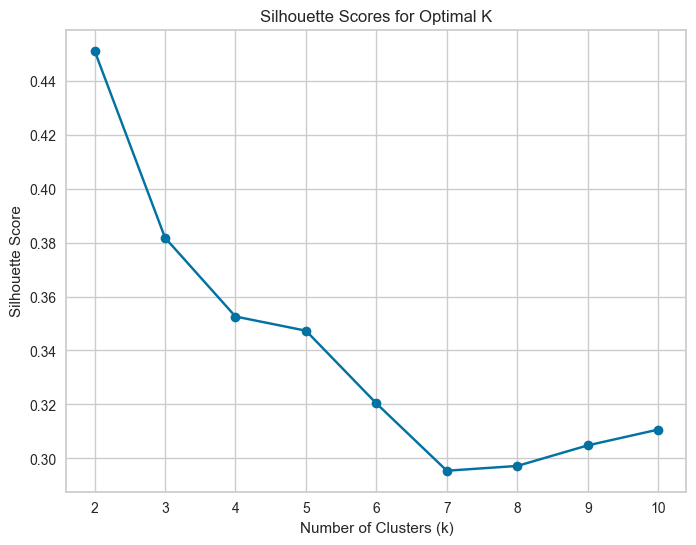

In [28]:
# Using Silhouette Score

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Using Silhouette Score

# List to store silhouette scores for each k value
sil_scores = []

# Calculate silhouette score for each k
for k in range(2, 11): 
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(PCA_ds)
    score = silhouette_score(PCA_ds, kmeans.labels_)
    sil_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), sil_scores, marker='o', color='b')  
plt.title('Silhouette Scores for Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')

# plt.savefig('/Users/shistatabagale/Downloads/Project_Final/Figure/SS.png')
plt.show()




The graph of Silhouette scores shows that the optimal number of cluster be 2 while the elbow method shows 4 as the optimal number of clusters.
So I have decided to compare the cluster 2, 3 and 4 and evaluate these clusters based on Silhouette score and Dunn's index and best model for this dataset will be identified.



In [29]:
# Perform K-Means clustering with n = 2
PCA_df = PCA_ds.copy()

kmeans_2 = KMeans(n_clusters=2, random_state=42)
PCA_df['Cluster_kMeans_2'] = kmeans_2.fit_predict(PCA_ds)

# Perform K-Means clustering with n = 4
kmeans_4 = KMeans(n_clusters=4, random_state=42)
PCA_df['Cluster__kMeans_4'] = kmeans_4.fit_predict(PCA_ds)

# Perform K-Means clustering with n = 3
kmeans_3 = KMeans(n_clusters=3, random_state=42)
PCA_df['Cluster__kMeans_3'] = kmeans_3.fit_predict(PCA_ds)

#Adding the Clusters feature to the orignal dataframe.
data["Clusters_2_kmeans"]= PCA_df['Cluster_kMeans_2'] 
data["Clusters_4_kmeans"]= PCA_df['Cluster__kMeans_4'] 
data["Clusters_3_kmeans"]= PCA_df['Cluster__kMeans_3'] 

PCA_df.head(2)



PCA1      PCA2      PCA3  Cluster_kMeans_2  Cluster__kMeans_4  \
0  4.722460 -0.630334 -0.163660                 1                  1   
1 -2.769746  0.282498  1.026544                 0                  0   

   Cluster__kMeans_3  
0                  1  
1                  2

# K means with n = 2

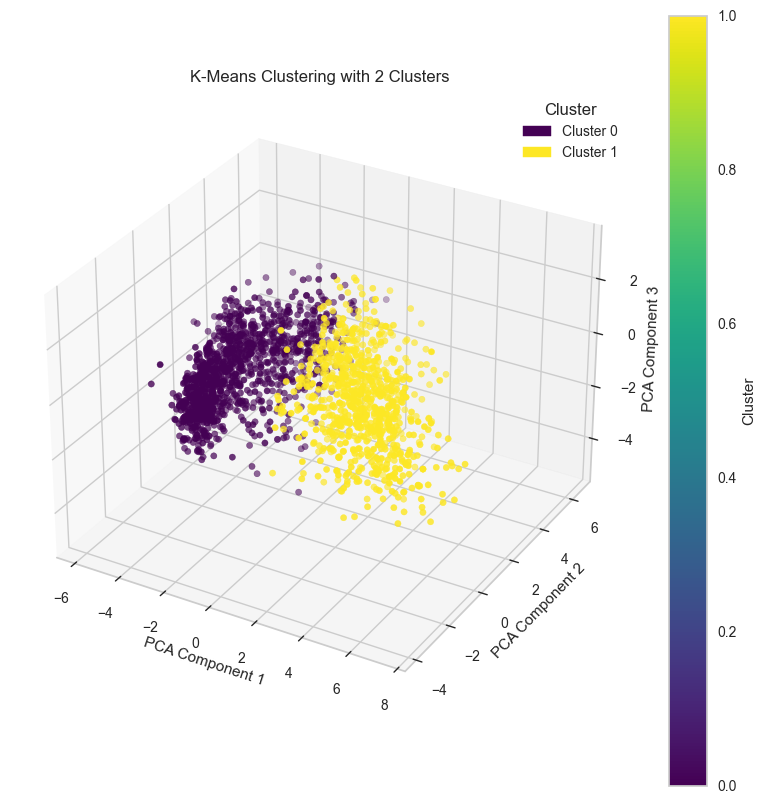

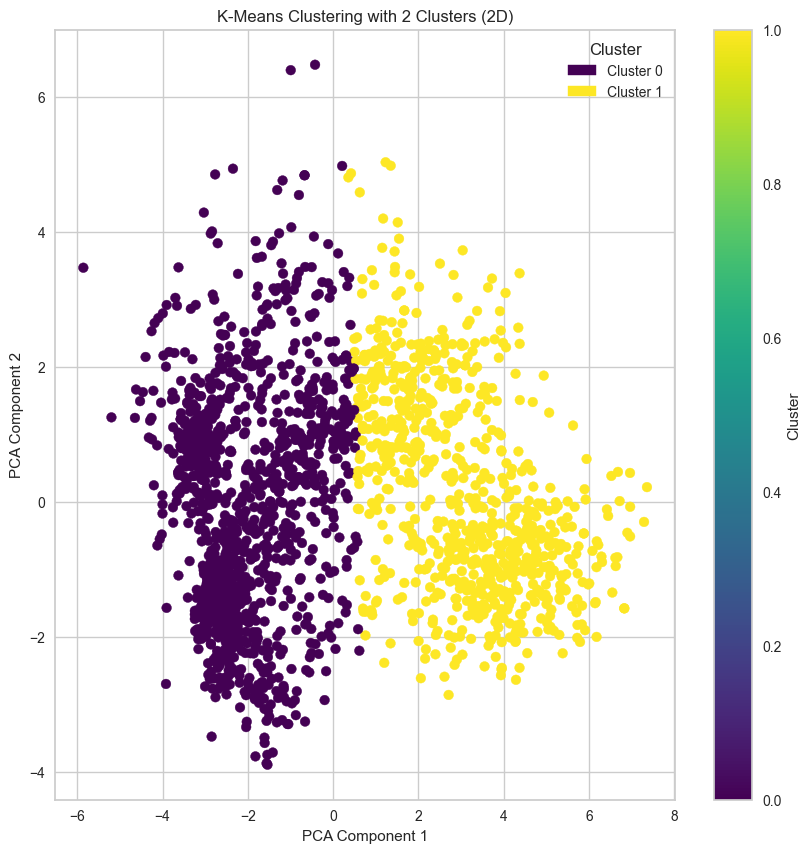

In [30]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches

# Create 3D scatter plot for n = 2 clusters
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for K-Means clustering with 2 clusters
scatter_2 = ax.scatter(PCA_ds.iloc[:, 0], PCA_ds.iloc[:, 1], PCA_ds.iloc[:, 2], c=PCA_df['Cluster_kMeans_2'], cmap='viridis')

# Add legend
import matplotlib.patches as mpatches
legend_labels = ['Cluster 0', 'Cluster 1']  
handles = [mpatches.Patch(color=scatter_2.cmap(scatter_2.norm(i)), label=label) 
           for i, label in enumerate(legend_labels)]
ax.legend(handles=handles, title='Cluster')

# Set titles and labels
ax.set_title('K-Means Clustering with 2 Clusters')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

# Add color bar to indicate cluster
fig.colorbar(scatter_2, label='Cluster')

plt.savefig('/Users/shistatabagale/Downloads/Project_Final/Figure/k-means2_3D.png')
plt.show()




##### --------------------------2D-------------------------

# Create 2D scatter plot for K-Means clustering with 2 clusters
fig, ax = plt.subplots(figsize=(10,10))

# Scatter plot for K-Means clustering using first two PCA components
scatter_2d = ax.scatter(PCA_ds.iloc[:, 0], PCA_ds.iloc[:, 1], c=PCA_df['Cluster_kMeans_2'], cmap='viridis')

legend_labels = ['Cluster 0', 'Cluster 1']  
handles = [mpatches.Patch(color=scatter_2d.cmap(scatter_2d.norm(i)), label=label) 
           for i, label in enumerate(legend_labels)]
ax.legend(handles=handles, title='Cluster')

# Set the title and axis labels
ax.set_title('K-Means Clustering with 2 Clusters (2D)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')

# Add color bar to indicate cluster assignments
fig.colorbar(scatter_2d, label='Cluster')

plt.savefig('/Users/shistatabagale/Downloads/Project_Final/Figure/k-means2_2D.png')
plt.show()

# K means, n=3

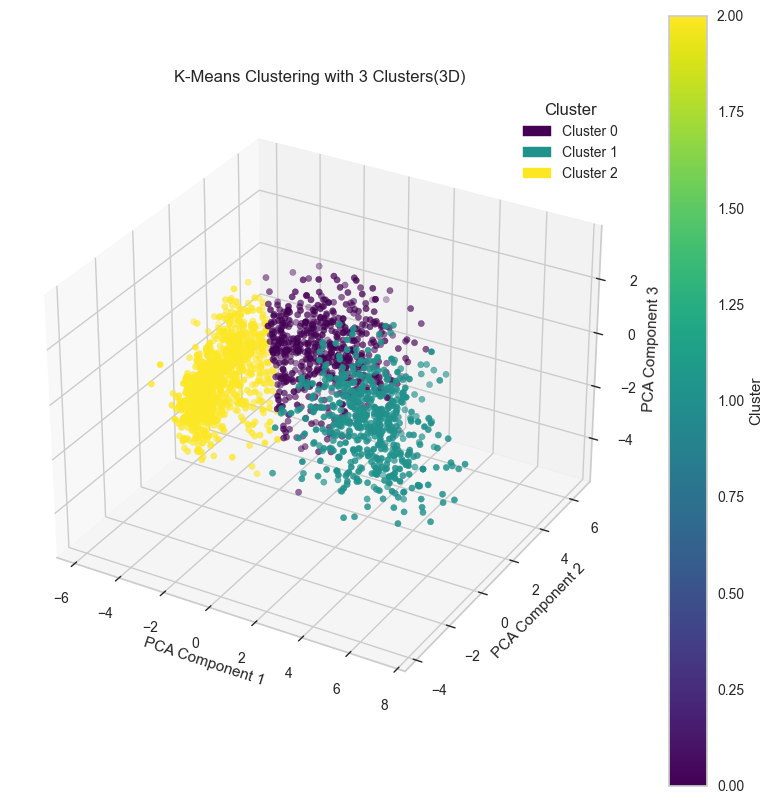

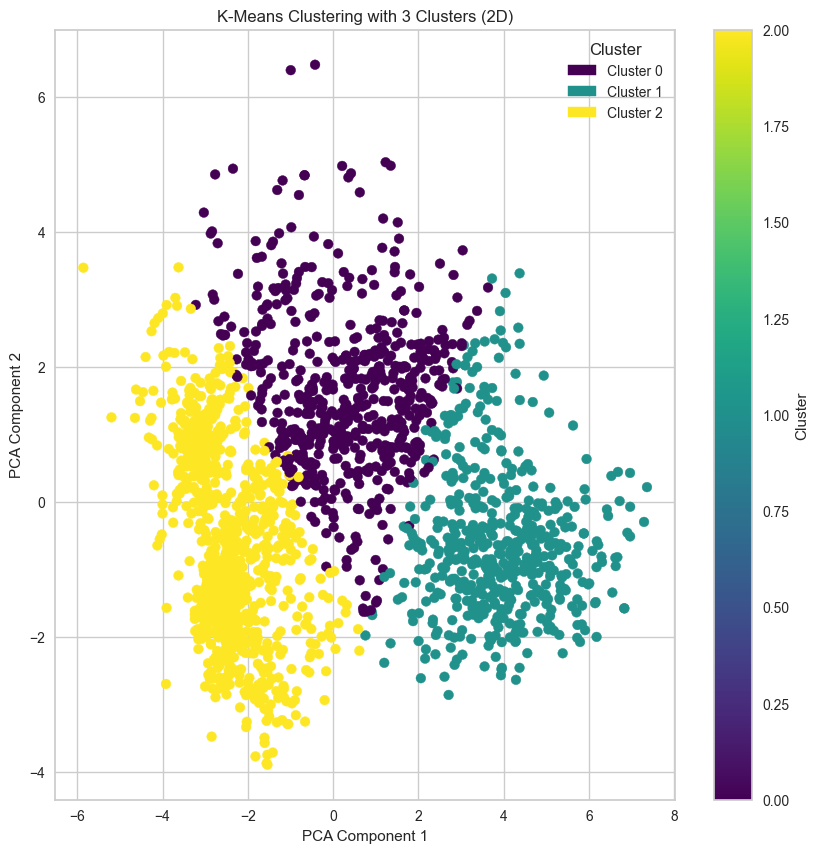

In [31]:
from mpl_toolkits.mplot3d import Axes3D

# Create 3D scatter plot for n = 3 clusters
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for K-Means clustering with 3 clusters
scatter_3 = ax.scatter(PCA_ds.iloc[:, 0], PCA_ds.iloc[:, 1], PCA_ds.iloc[:, 2], c=PCA_df['Cluster__kMeans_3'], cmap='viridis')

legend_labels = ['Cluster 0', 'Cluster 1', 'Cluster 2']  
handles = [mpatches.Patch(color=scatter_3.cmap(scatter_3.norm(i)), label=label) 
           for i, label in enumerate(legend_labels)]
ax.legend(handles=handles, title='Cluster')

ax.set_title('K-Means Clustering with 3 Clusters(3D)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
fig.colorbar(scatter_3, label='Cluster')

# plt.savefig('/Users/shistatabagale/Downloads/Project_Final/Figure/k-means3_3D.png')
plt.show()


# Create 2D scatter plot for K-Means clustering with 3 clusters
fig, ax = plt.subplots(figsize=(10,10))

# Scatter plot for K-Means clustering using first two PCA components
scatter_3d = ax.scatter(PCA_ds.iloc[:, 0], PCA_ds.iloc[:, 1], c=PCA_df['Cluster__kMeans_3'], cmap='viridis')

legend_labels = ['Cluster 0', 'Cluster 1', 'Cluster 2']  
handles = [mpatches.Patch(color=scatter_3d.cmap(scatter_3d.norm(i)), label=label) 
           for i, label in enumerate(legend_labels)]
ax.legend(handles=handles, title='Cluster')

# Set the title and axis labels
ax.set_title('K-Means Clustering with 3 Clusters (2D)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')

# Add color bar to indicate cluster assignments
fig.colorbar(scatter_3d, label='Cluster')

# plt.savefig('/Users/shistatabagale/Downloads/Project_Final/Figure/k-means3_2D.png')
plt.show()


# K means using n=4

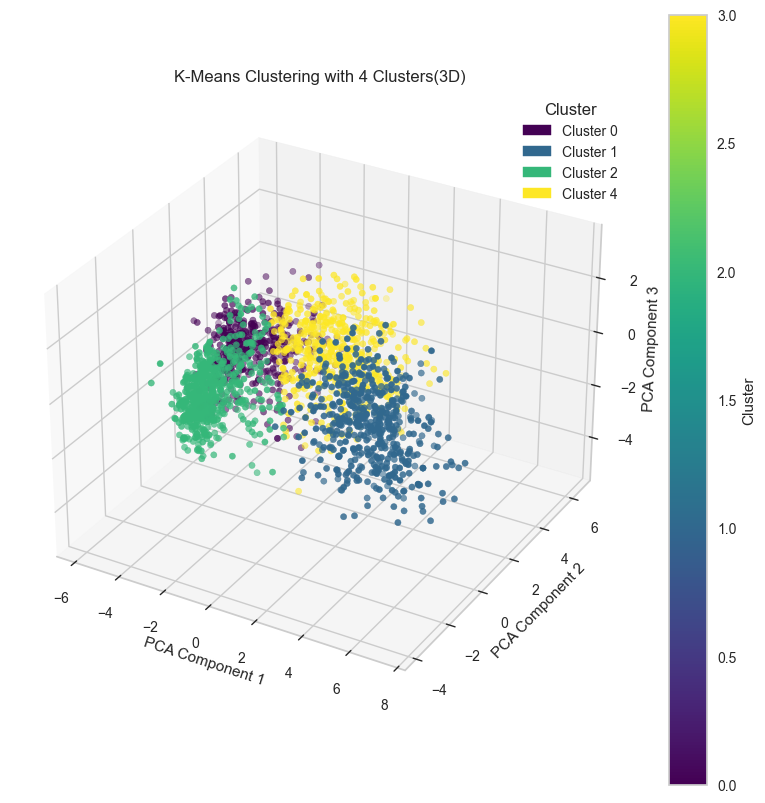

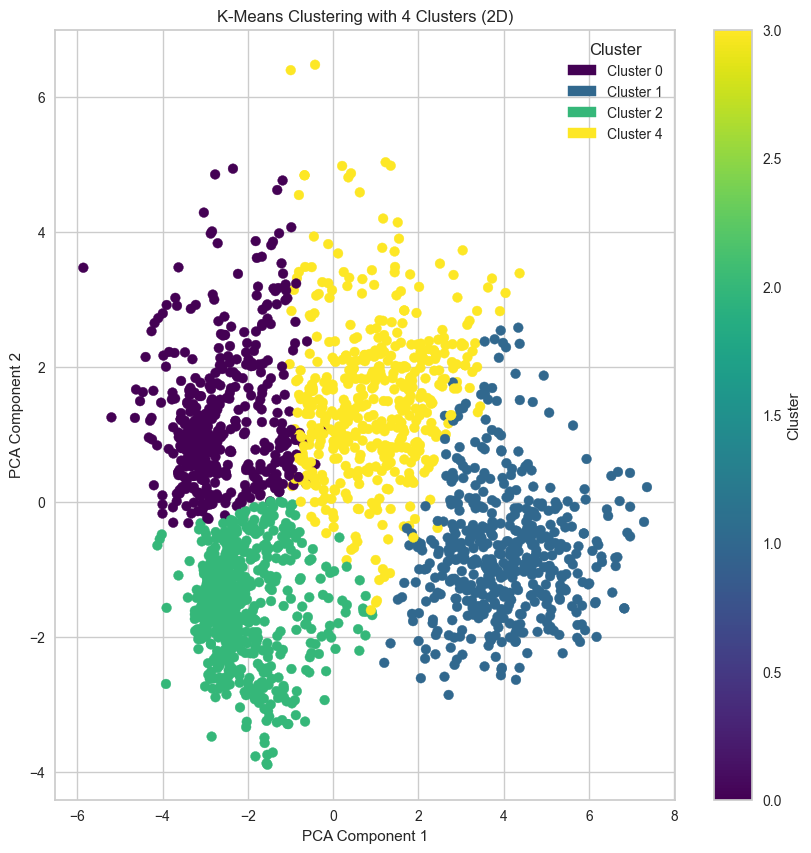

In [32]:
from mpl_toolkits.mplot3d import Axes3D

# Create 3D scatter plot for n = 4 clusters
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for K-Means clustering with 4 clusters
scatter_4 = ax.scatter(PCA_ds.iloc[:, 0], PCA_ds.iloc[:, 1], PCA_ds.iloc[:, 2], c=PCA_df['Cluster__kMeans_4'], cmap='viridis')

legend_labels = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 4']  
handles = [mpatches.Patch(color=scatter_4.cmap(scatter_4.norm(i)), label=label) 
           for i, label in enumerate(legend_labels)]
ax.legend(handles=handles, title='Cluster')

ax.set_title('K-Means Clustering with 4 Clusters(3D)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
fig.colorbar(scatter_4, label='Cluster')

# plt.savefig('/Users/shistatabagale/Downloads/Project_Final/Figure/k-means4_3D.png')
plt.show()


# Create 2D scatter plot for K-Means clustering with 4 clusters
fig, ax = plt.subplots(figsize=(10,10))

# Scatter plot for K-Means clustering using first two PCA components
scatter_4d = ax.scatter(PCA_ds.iloc[:, 0], PCA_ds.iloc[:, 1], c=PCA_df['Cluster__kMeans_4'], cmap='viridis')

legend_labels = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 4']  
handles = [mpatches.Patch(color=scatter_4d.cmap(scatter_4d.norm(i)), label=label) 
           for i, label in enumerate(legend_labels)]
ax.legend(handles=handles, title='Cluster')

# Set the title and axis labels
ax.set_title('K-Means Clustering with 4 Clusters (2D)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')

# Add color bar to indicate cluster assignments
fig.colorbar(scatter_4d, label='Cluster')
# plt.savefig('/Users/shistatabagale/Downloads/Project_Final/Figure/k-means4_2D.png')
plt.show()


In [33]:
# Display first few rows of the dataset with cluster labels
print(PCA_df.head(2))


       PCA1      PCA2      PCA3  Cluster_kMeans_2  Cluster__kMeans_4  \
0  4.722460 -0.630334 -0.163660                 1                  1   
1 -2.769746  0.282498  1.026544                 0                  0   

   Cluster__kMeans_3  
0                  1  
1                  2  


In [34]:
# Count the number of data points in each cluster for k=2
cluster_count_2 = PCA_df['Cluster_kMeans_2'].value_counts()
print("Cluster distribution for k=2:")
print(cluster_count_2)

# Count the number of data points in each cluster for k=3
cluster_count_3 = PCA_df['Cluster__kMeans_3'].value_counts()
print("Cluster distribution for k=3:")
print(cluster_count_3)

# Count the number of data points in each cluster for k=4
cluster_count_4 = PCA_df['Cluster__kMeans_4'].value_counts()
print("Cluster distribution for k=4:")
print(cluster_count_4)


Cluster distribution for k=2:
Cluster_kMeans_2
0    1217
1     789
Name: count, dtype: int64
Cluster distribution for k=3:
Cluster__kMeans_3
2    907
0    576
1    523
Name: count, dtype: int64
Cluster distribution for k=4:
Cluster__kMeans_4
2    593
3    488
1    482
0    443
Name: count, dtype: int64


# Spectral Clustering


In [35]:
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import NearestNeighbors

In [36]:

n_clusters = 2 
# Perform Spectral Clustering
spectral2 = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
# Fit the model and predict cluster labels
PCA_df['Spectral_Cluster_2'] = spectral2.fit_predict(PCA_ds)

n_clusters = 3
# Perform Spectral Clustering
spectral3 = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
# Fit the model and predict cluster labels
PCA_df['Spectral_Cluster_3'] = spectral3.fit_predict(PCA_ds)

n_clusters = 4
# Perform Spectral Clustering
spectral4 = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
# Fit the model and predict cluster labels
PCA_df['Spectral_Cluster_4'] = spectral4.fit_predict(PCA_ds)


#Adding the Clusters feature to the orignal dataframe.
data["Clusters_2_Spectral"]= PCA_df['Spectral_Cluster_2']
data["Clusters_3_Spectral"]= PCA_df['Spectral_Cluster_3'] 
data["Clusters_4_Spectral"]= PCA_df['Spectral_Cluster_4'] 


print(PCA_df.head())

       PCA1      PCA2      PCA3  Cluster_kMeans_2  Cluster__kMeans_4  \
0  4.722460 -0.630334 -0.163660                 1                  1   
1 -2.769746  0.282498  1.026544                 0                  0   
2  2.297565 -0.568668  0.002010                 1                  1   
3 -2.634284 -1.475797 -1.016178                 0                  2   
4 -0.432546  0.338115 -0.934404                 0                  3   

   Cluster__kMeans_3  Spectral_Cluster_2  Spectral_Cluster_3  \
0                  1                   1                   1   
1                  2                   0                   0   
2                  1                   1                   1   
3                  2                   0                   2   
4                  0                   0                   0   

   Spectral_Cluster_4  
0                   1  
1                   0  
2                   1  
3                   3  
4                   2  


# Spectral using k = 2

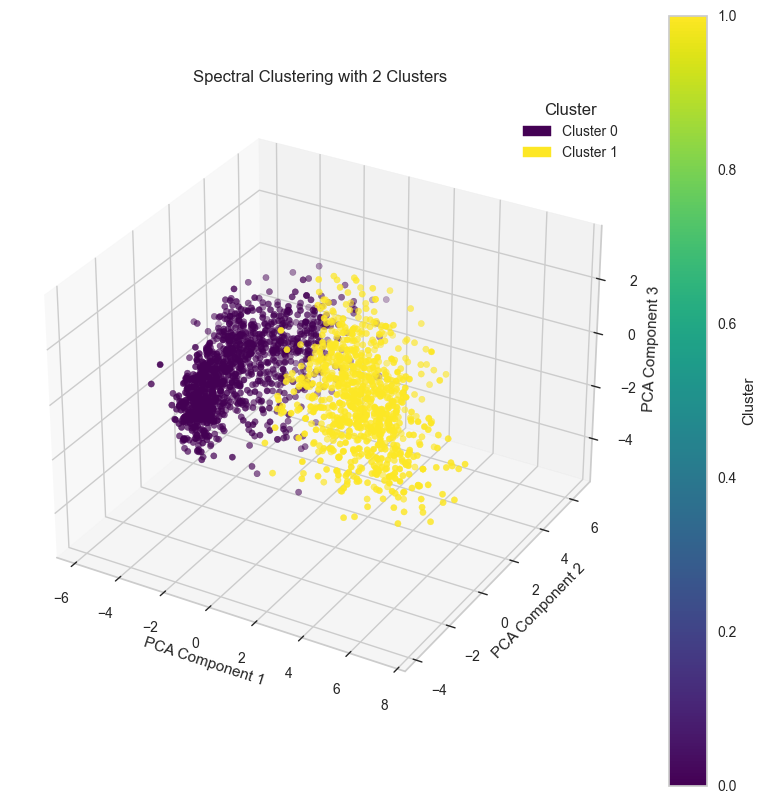

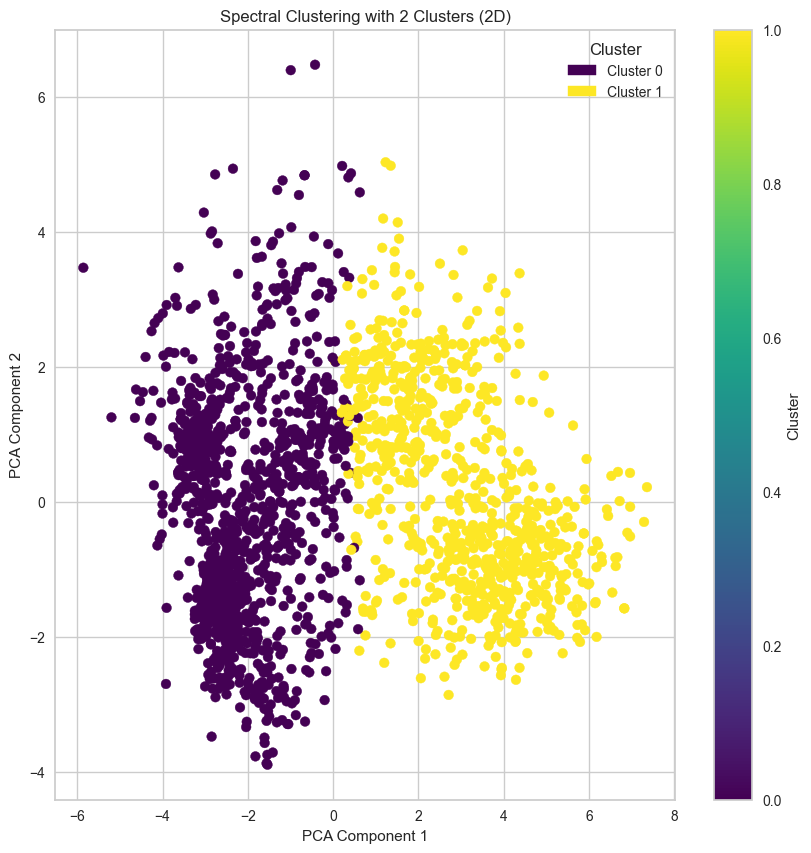

In [37]:
from mpl_toolkits.mplot3d import Axes3D

# Create 3D scatter plot for n = 2 clusters
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for Spectral  clustering with 2 clusters
scatter_2s = ax.scatter(PCA_ds.iloc[:, 0], PCA_ds.iloc[:, 1], PCA_ds.iloc[:, 2], c=PCA_df['Spectral_Cluster_2'], cmap='viridis')

legend_labels = ['Cluster 0', 'Cluster 1']  
handles = [mpatches.Patch(color=scatter_2s.cmap(scatter_2s.norm(i)), label=label) 
           for i, label in enumerate(legend_labels)]
ax.legend(handles=handles, title='Cluster')

ax.set_title('Spectral Clustering with 2 Clusters')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
fig.colorbar(scatter_2s, label='Cluster')

# plt.savefig('/Users/shistatabagale/Downloads/Project_Final/Figure/k-means2_3D.png')
plt.show()


##### --------------------------2D-------------------------

# Create 2D scatter plot for Spectral clustering with 2 clusters
fig, ax = plt.subplots(figsize=(10,10))

# Scatter plot for Spectral clustering using first two PCA components
scatter_2ds = ax.scatter(PCA_ds.iloc[:, 0], PCA_ds.iloc[:, 1], c=PCA_df['Spectral_Cluster_2'], cmap='viridis')


legend_labels = ['Cluster 0', 'Cluster 1']  
handles = [mpatches.Patch(color=scatter_2ds.cmap(scatter_2ds.norm(i)), label=label) 
           for i, label in enumerate(legend_labels)]
ax.legend(handles=handles, title='Cluster')


# Set the title and axis labels
ax.set_title('Spectral Clustering with 2 Clusters (2D)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')

# Add color bar to indicate cluster assignments
fig.colorbar(scatter_2ds, label='Cluster')

# plt.savefig('/Users/shistatabagale/Downloads/Project_Final/Figure/Spectral2_2D.png')
plt.show()

# Spectral using k=3

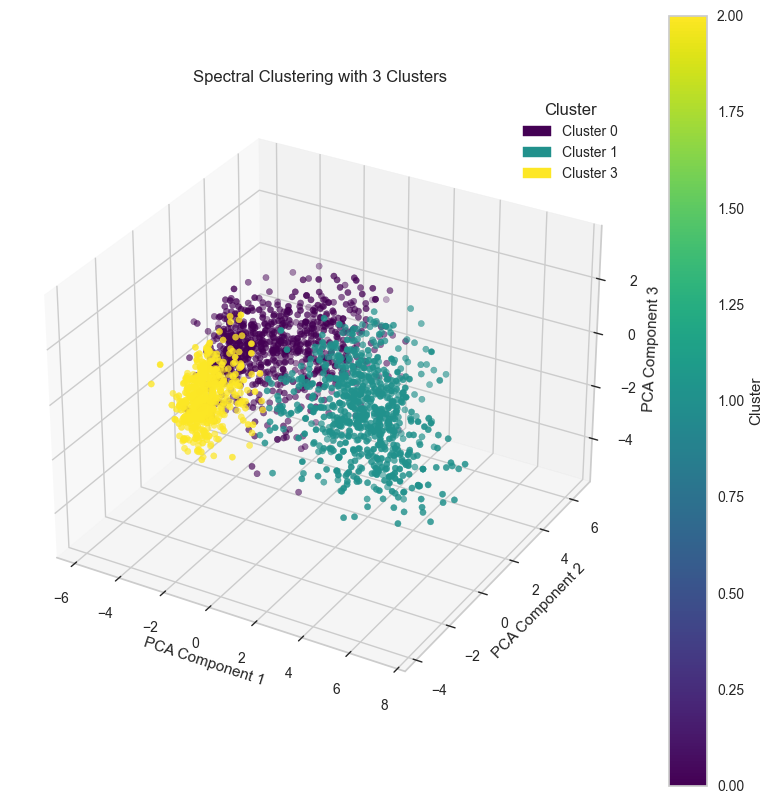

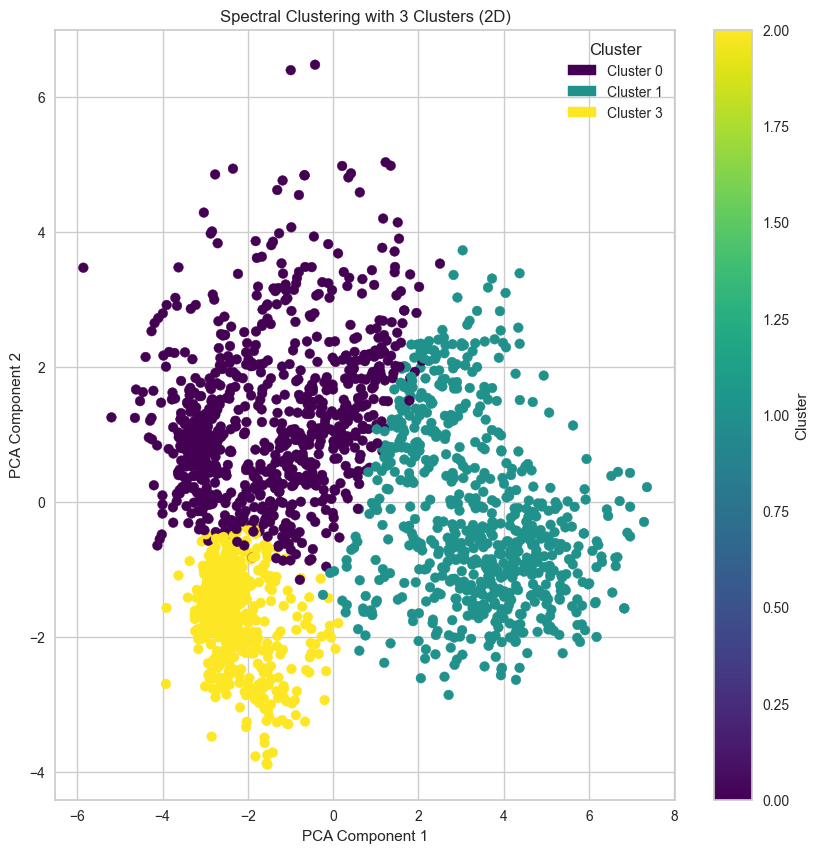

In [38]:
from mpl_toolkits.mplot3d import Axes3D

# Create 3D scatter plot for n = 3 clusters
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for Spectral  clustering with 3 clusters
scatter_3s = ax.scatter(PCA_ds.iloc[:, 0], PCA_ds.iloc[:, 1], PCA_ds.iloc[:, 2], c=PCA_df['Spectral_Cluster_3'], cmap='viridis')


legend_labels = ['Cluster 0', 'Cluster 1', 'Cluster 3']  
handles = [mpatches.Patch(color=scatter_3s.cmap(scatter_3s.norm(i)), label=label) 
           for i, label in enumerate(legend_labels)]
ax.legend(handles=handles, title='Cluster')


ax.set_title('Spectral Clustering with 3 Clusters')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
fig.colorbar(scatter_3s, label='Cluster')

# plt.savefig('/Users/shistatabagale/Downloads/Project_Final/Figure/Spectral3_3D.png')
plt.show()


##### --------------------------2D-------------------------

# Create 2D scatter plot for Spectral clustering with 3 clusters
fig, ax = plt.subplots(figsize=(10,10))

# Scatter plot for Spectral clustering using first two PCA components
scatter_3ds = ax.scatter(PCA_ds.iloc[:, 0], PCA_ds.iloc[:, 1], c=PCA_df['Spectral_Cluster_3'], cmap='viridis')

legend_labels = ['Cluster 0', 'Cluster 1', 'Cluster 3']  
handles = [mpatches.Patch(color=scatter_3ds.cmap(scatter_3ds.norm(i)), label=label) 
           for i, label in enumerate(legend_labels)]
ax.legend(handles=handles, title='Cluster')

# Set the title and axis labels
ax.set_title('Spectral Clustering with 3 Clusters (2D)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')

# Add color bar to indicate cluster assignments
fig.colorbar(scatter_3ds, label='Cluster')

# plt.savefig('/Users/shistatabagale/Downloads/Project_Final/Figure/Spectral3_2D.png')
plt.show()

# Spectral using k=4

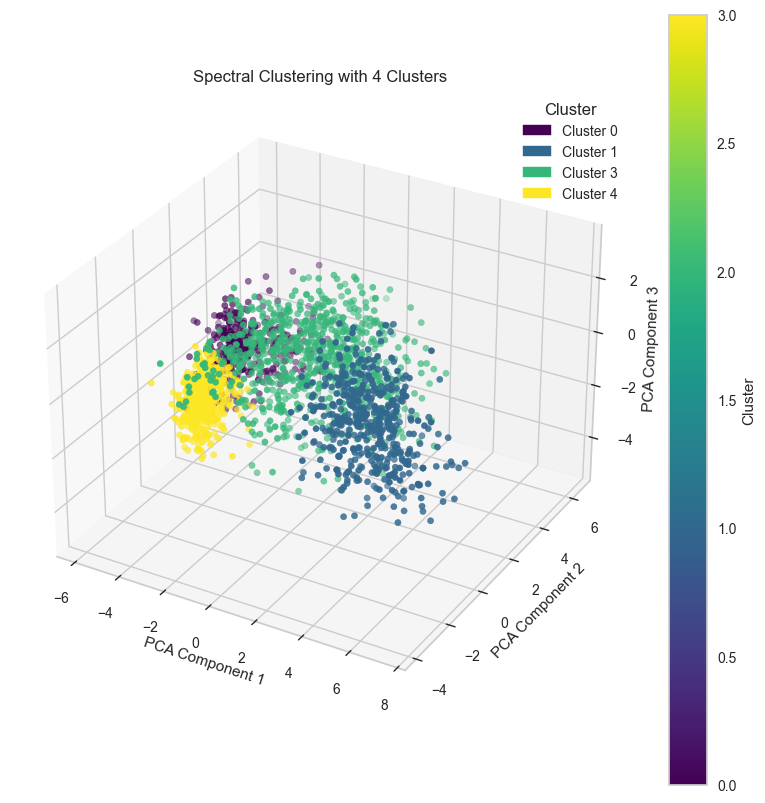

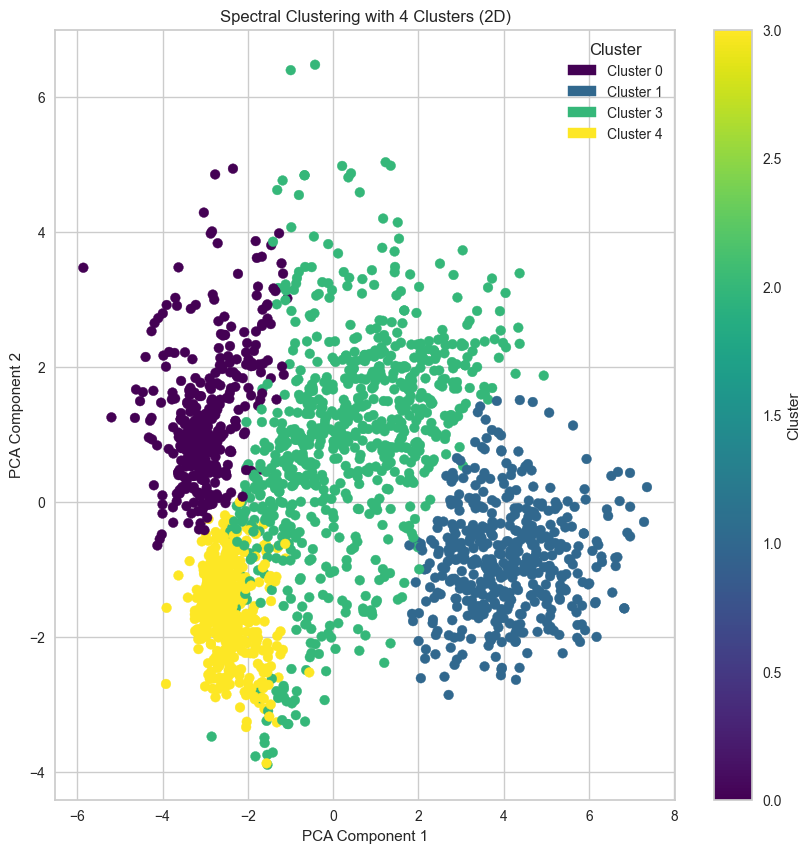

In [39]:
from mpl_toolkits.mplot3d import Axes3D

# Create 3D scatter plot for n = 4 clusters
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for Spectral  clustering with 3 clusters
scatter_4s = ax.scatter(PCA_ds.iloc[:, 0], PCA_ds.iloc[:, 1], PCA_ds.iloc[:, 2], c=PCA_df['Spectral_Cluster_4'], cmap='viridis')

legend_labels = ['Cluster 0', 'Cluster 1', 'Cluster 3', 'Cluster 4']  
handles = [mpatches.Patch(color=scatter_4s.cmap(scatter_4s.norm(i)), label=label) 
           for i, label in enumerate(legend_labels)]
ax.legend(handles=handles, title='Cluster')

ax.set_title('Spectral Clustering with 4 Clusters')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
fig.colorbar(scatter_4s, label='Cluster')

# plt.savefig('/Users/shistatabagale/Downloads/Project_Final/Figure/Spectral4_3D.png')
plt.show()


##### --------------------------2D-------------------------

# Create 2D scatter plot for Spectral clustering with 4 clusters
fig, ax = plt.subplots(figsize=(10,10))

# Scatter plot for Spectral clustering using first two PCA components
scatter_4ds = ax.scatter(PCA_ds.iloc[:, 0], PCA_ds.iloc[:, 1], c=PCA_df['Spectral_Cluster_4'], cmap='viridis')

legend_labels = ['Cluster 0', 'Cluster 1', 'Cluster 3', 'Cluster 4']  
handles = [mpatches.Patch(color=scatter_4ds.cmap(scatter_4ds.norm(i)), label=label) 
           for i, label in enumerate(legend_labels)]
ax.legend(handles=handles, title='Cluster')

# Set the title and axis labels
ax.set_title('Spectral Clustering with 4 Clusters (2D)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')

# Add color bar to indicate cluster assignments
fig.colorbar(scatter_4ds, label='Cluster')

#a
plt.show()

In [71]:
AC = AgglomerativeClustering(n_clusters=3)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_df["Clusters_AG"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
data["Clusters_AG"]= yhat_AC

# Model Evaluation

In [72]:
data.head(2)

Education  Marital_Status   Income  Kidhome  Teenhome  Recency  Wines  \
0          2               0  58138.0        0         0       58    635   
1          2               0  46344.0        1         1       38     11   

   Fruits  Meat  Fish  ...  Family_Size  Total_Expenses  Clusters_2_kmeans  \
0      88   546   172  ...            1            1617                1.0   
1       1     6     2  ...            3              27                0.0   

   Clusters_4_kmeans  Clusters_3_kmeans  Clusters_2_Spectral  \
0                1.0                1.0                  1.0   
1                0.0                2.0                  0.0   

   Clusters_3_Spectral  Clusters_4_Spectral  Clusters_AG  Total_Promos  
0                  1.0                  1.0            2             0  
1                  0.0                  0.0            0             0  

[2 rows x 36 columns]

In [73]:
from sklearn.metrics import silhouette_score


# Extract the feature columns (PCA1, PCA2, PCA3)
X = PCA_df[['PCA1', 'PCA2', 'PCA3']]

# List of clustering columns to evaluate
clustering_columns = ['Cluster_kMeans_2', 'Cluster__kMeans_4', 'Cluster__kMeans_3', 'Spectral_Cluster_2', 'Spectral_Cluster_3', 'Spectral_Cluster_4', 'Clusters_AG']

# Initialize variables to track the best clustering
best_score = -1  # Silhouette score can be between -1 and 1, so we start with a low value
best_clustering = ""
# Calculate silhouette score for each clustering result
for clustering_column in clustering_columns:
    cluster_labels = PCA_df[clustering_column]
    score = silhouette_score(X, cluster_labels)
    print(f"Silhouette score for {clustering_column}: {score}")

    if score > best_score:
        best_score = score
        best_clustering = clustering_column

print(f"The best clustering is: {best_clustering} with a silhouette score of {best_score:.4f}")


Silhouette score for Cluster_kMeans_2: 0.45106666324162376
Silhouette score for Cluster__kMeans_4: 0.3525822501685015
Silhouette score for Cluster__kMeans_3: 0.38177023977149754
Silhouette score for Spectral_Cluster_2: 0.44880878081516357
Silhouette score for Spectral_Cluster_3: 0.344985701429095
Silhouette score for Spectral_Cluster_4: 0.3143932928151658
Silhouette score for Clusters_AG: 0.36017191778967145
The best clustering is: Cluster_kMeans_2 with a silhouette score of 0.4511


In [83]:
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances

def dunn_index(X, labels):
    """
    Compute the Dunn's index for clustering.
    
    Parameters:
    - X: The data points (features) used in clustering (e.g., PCA components).
    - labels: The cluster labels for each data point.

    Returns:
    - Dunn's index: A measure of the clustering quality.
    """
    n_clusters = len(np.unique(labels))
    
    # Calculate intra-cluster distances (max distance within each cluster)
    intra_cluster_distances = []
    for label in np.unique(labels):
        cluster_points = X[labels == label]
        if len(cluster_points) > 1:
            distances = pairwise_distances(cluster_points)
            # The intra-cluster distance is the maximum distance between any two points in the same cluster
            max_distance = np.max(distances)
            intra_cluster_distances.append(max_distance)
    
    # Calculate inter-cluster distances (min distance between different clusters)
    inter_cluster_distances = []
    for i in range(n_clusters):
        for j in range(i + 1, n_clusters):
            # Find points belonging to cluster i and cluster j
            points_i = X[labels == i]
            points_j = X[labels == j]
            # Compute pairwise distances between points in different clusters
            distances = pairwise_distances(points_i, points_j)
            # The inter-cluster distance is the minimum distance between any point in cluster i and any point in cluster j
            min_distance = np.min(distances)
            inter_cluster_distances.append(min_distance)
    
    # Dunn's index is the ratio of the minimum inter-cluster distance to the maximum intra-cluster distance
    dunn_index_value = np.min(inter_cluster_distances) / np.max(intra_cluster_distances)
    
    return dunn_index_value

# Example: Evaluate Dunn's Index for one clustering result
clustering_columns = ['Cluster_kMeans_2', 'Cluster__kMeans_4', 'Cluster__kMeans_3', 'Spectral_Cluster_2', 'Spectral_Cluster_3', 'Spectral_Cluster_4','Clusters_AG' ]

# Extract the PCA features (assuming they are PCA1, PCA2, PCA3)
X = PCA_df[['PCA1', 'PCA2', 'PCA3']].values  # Features (PCA components)

best_dunn_index = -np.inf  # Start with a very low value (since Dunn's index is always positive)
best_clustering = ""

# Calculate Dunn's Index for each clustering result
for clustering_column in clustering_columns:
    cluster_labels = PCA_df[clustering_column].values
    dunn_value = dunn_index(X, cluster_labels)
    print(f"Dunn's Index for {clustering_column}: {dunn_value:.4f}")

    if dunn_value > best_dunn_index:
        best_dunn_index = dunn_value
        best_clustering = clustering_column

print(f"The best clustering based on Dunn's Index is: {best_clustering} with a Dunn's Index of {best_dunn_index:.4f}")


Dunn's Index for Cluster_kMeans_2: 0.0078
Dunn's Index for Cluster__kMeans_4: 0.0125
Dunn's Index for Cluster__kMeans_3: 0.0111
Dunn's Index for Spectral_Cluster_2: 0.0179
Dunn's Index for Spectral_Cluster_3: 0.0112
Dunn's Index for Spectral_Cluster_4: 0.0093
Dunn's Index for Clusters_AG: 0.0334
The best clustering based on Dunn's Index is: Clusters_AG with a Dunn's Index of 0.0334


Based on the evaluation metrices, the k-means with 2 clusters performed better in this dataset.

In [93]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2006 entries, 0 to 2239
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2006 non-null   int64  
 1   Marital_Status       2006 non-null   int64  
 2   Income               2006 non-null   float64
 3   Kidhome              2006 non-null   int64  
 4   Teenhome             2006 non-null   int64  
 5   Recency              2006 non-null   int64  
 6   Wines                2006 non-null   int64  
 7   Fruits               2006 non-null   int64  
 8   Meat                 2006 non-null   int64  
 9   Fish                 2006 non-null   int64  
 10  Sweets               2006 non-null   int64  
 11  Gold                 2006 non-null   int64  
 12  NumDealsPurchases    2006 non-null   int64  
 13  NumWebPurchases      2006 non-null   int64  
 14  NumCatalogPurchases  2006 non-null   int64  
 15  NumStorePurchases    2006 non-null   int64 

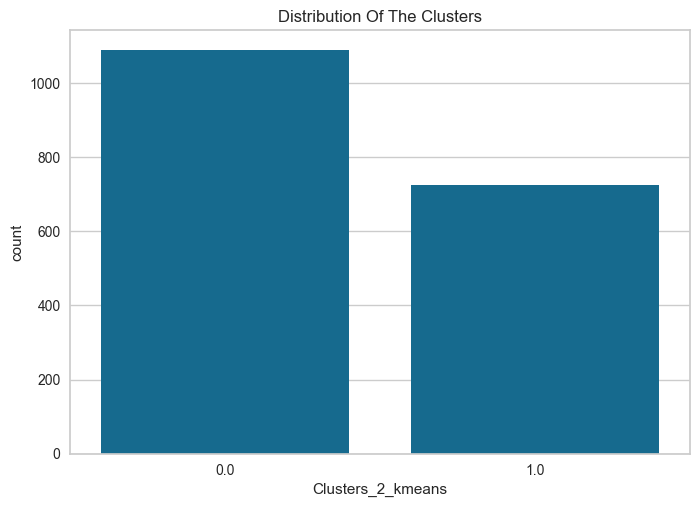

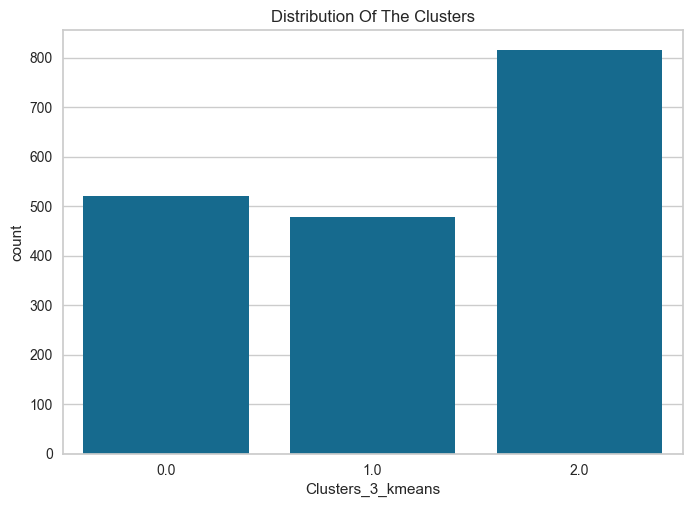

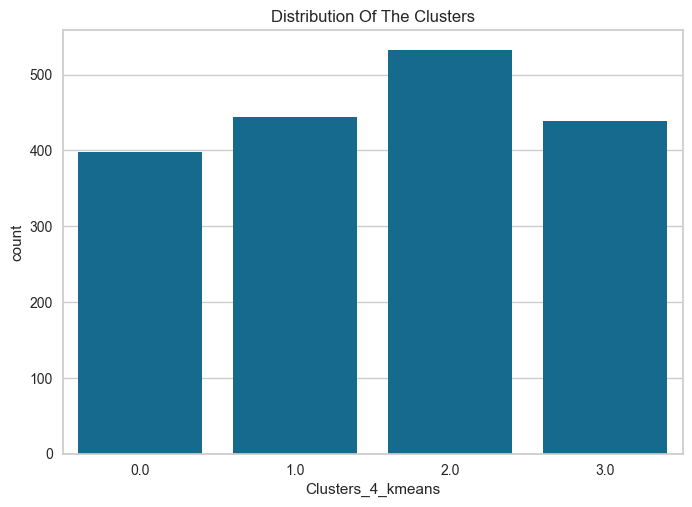

In [76]:
#Plotting countplot of clusters

pl = sns.countplot(x=data["Clusters_2_kmeans"])
pl.set_title("Distribution Of The Clusters")
plt.show()

pl = sns.countplot(x=data["Clusters_3_kmeans"])
pl.set_title("Distribution Of The Clusters")
plt.show()

pl = sns.countplot(x=data["Clusters_4_kmeans"])
pl.set_title("Distribution Of The Clusters")
plt.show()

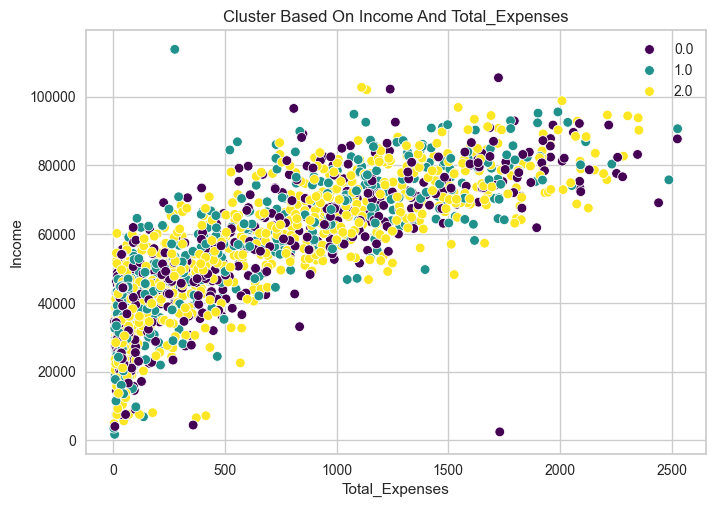

In [77]:
#Income vs spending plot shows the clusters pattern

pl = sns.scatterplot(data = data,x=data["Total_Expenses"], y=data["Income"],hue=data["Clusters_3_kmeans"], palette='viridis')
pl.set_title("Cluster Based On Income And Total_Expenses")
plt.legend()


plt.show()

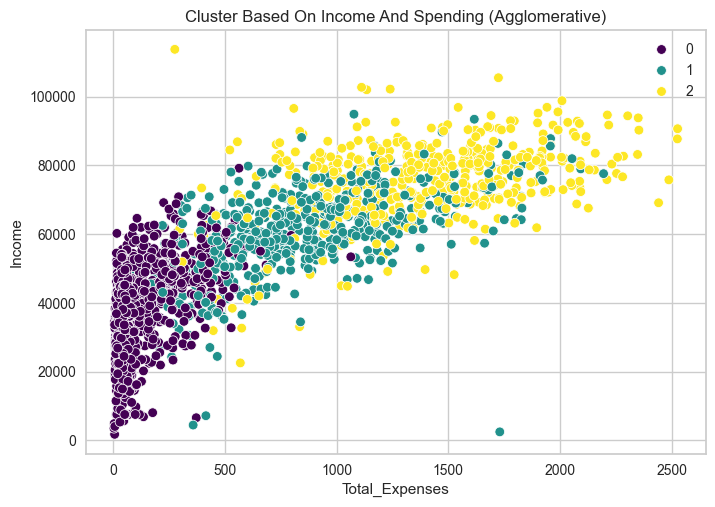

In [80]:
pl = sns.scatterplot(data = data,x=data["Total_Expenses"], y=data["Income"],hue=data["Clusters_AG"], palette='viridis')
pl.set_title("Cluster Based On Income And Spending (Agglomerative)")
plt.legend()
plt.show()

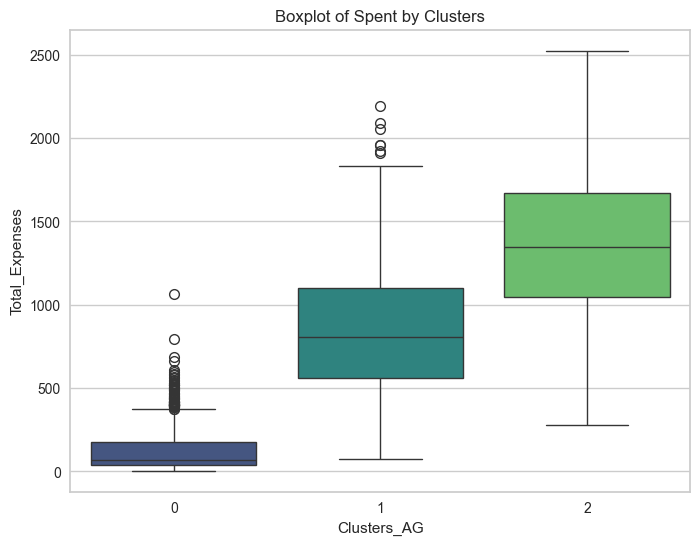

In [ ]:

# Set the color palette for the boxplot
pal = "viridis" 

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x="Clusters_AG", y="Total_Expenses", data=data, palette=pal)

# Add a title to the plot
plt.title('Boxplot of Spent by Clusters')

# Show the plot
plt.show()

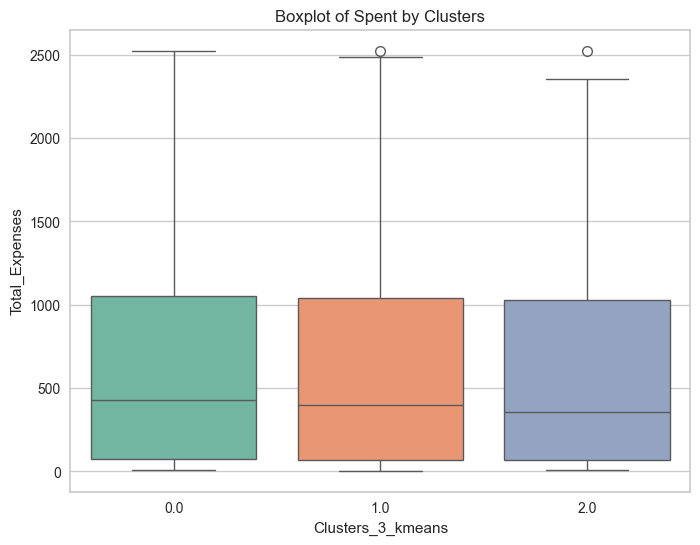

In [ ]:

# Set the color palette for the boxplot
pal = "Set2"  

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x="Clusters_3_kmeans", y="Total_Expenses", data=data, palette=pal)

# Add a title to the plot
plt.title('Boxplot of Spent by Clusters')

# Show the plot
plt.show()




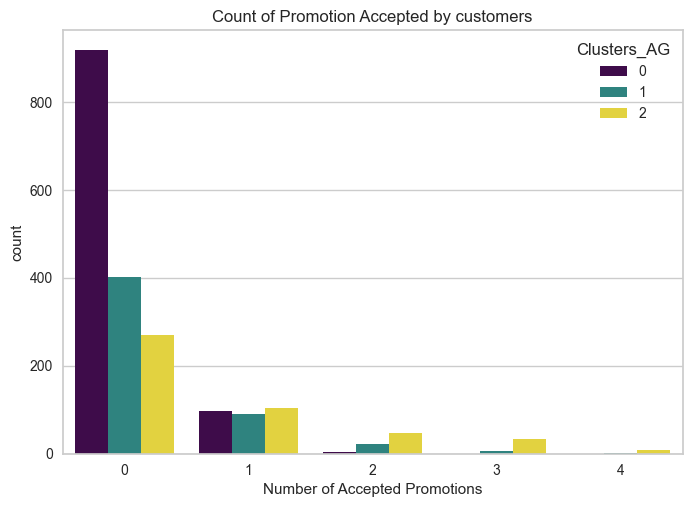

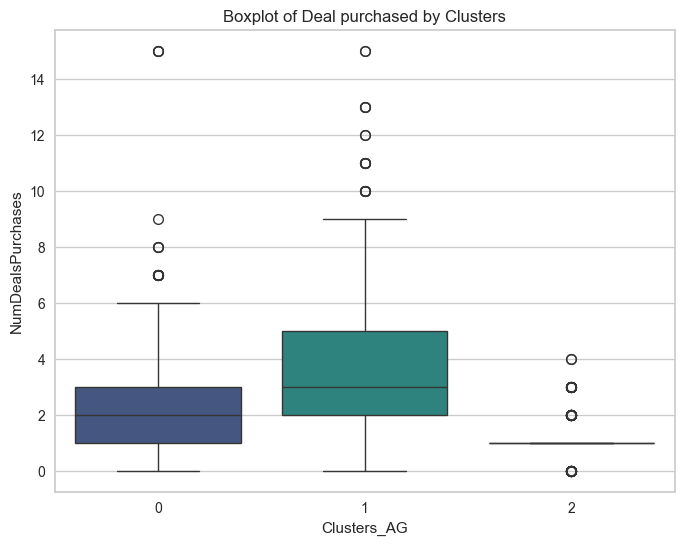

In [ ]:

#Creating a feature to get a sum of accepted promotions 
data["Total_Promos"] = data["AcceptedCmp1"]+ data["AcceptedCmp2"]+ data["AcceptedCmp3"]+ data["AcceptedCmp4"]+ data["AcceptedCmp5"]
#Plotting count of total campaign accepted.
plt.figure()
pl = sns.countplot(x=data["Total_Promos"],hue=data["Clusters_AG"], palette='viridis')
pl.set_title("Count of Promotion Accepted by customers")
pl.set_xlabel("Number of Accepted Promotions")
plt.show()



#Deal purchase 
# Set the color palette for the boxplot
pal = "viridis"  

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x="Clusters_AG", y="NumDealsPurchases", data=data, palette=pal)

# Add a title to the plot
plt.title('Boxplot of Deal purchased by Clusters')

# Show the plot
plt.show()

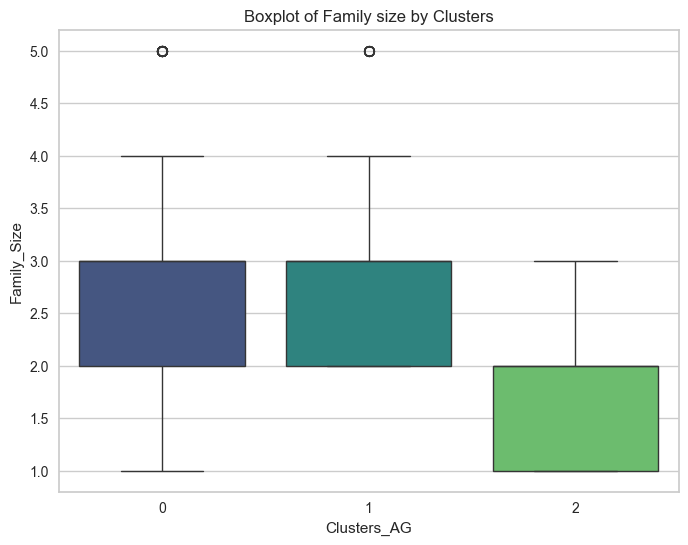

In [ ]:
#Deal purchase 
# Set the color palette for the boxplot
pal = "viridis"  

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x="Clusters_AG", y="Family_Size", data=data, palette=pal)

# Add a title to the plot
plt.title('Boxplot of Family size by Clusters')

# Show the plot
plt.show()

<Figure size 800x600 with 0 Axes>

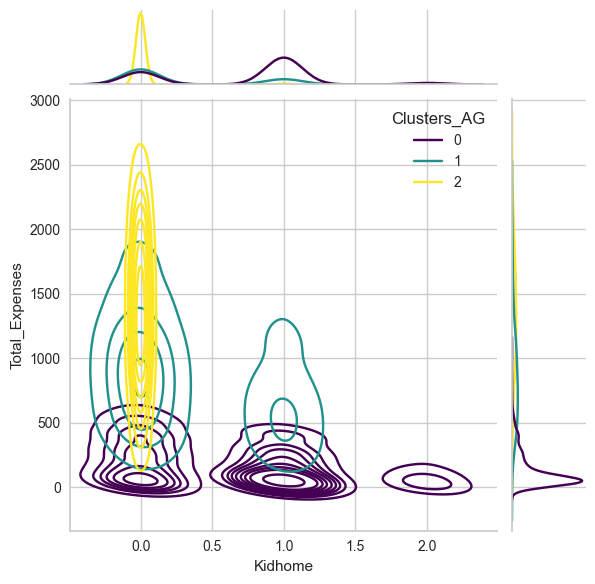

<Figure size 800x600 with 0 Axes>

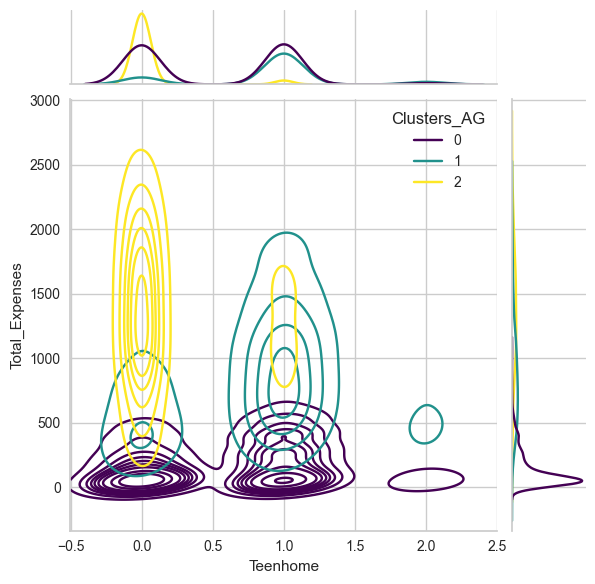

<Figure size 800x600 with 0 Axes>

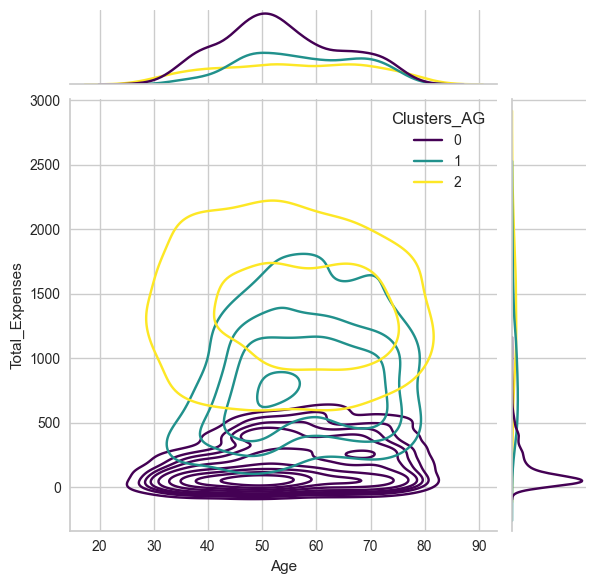

<Figure size 800x600 with 0 Axes>

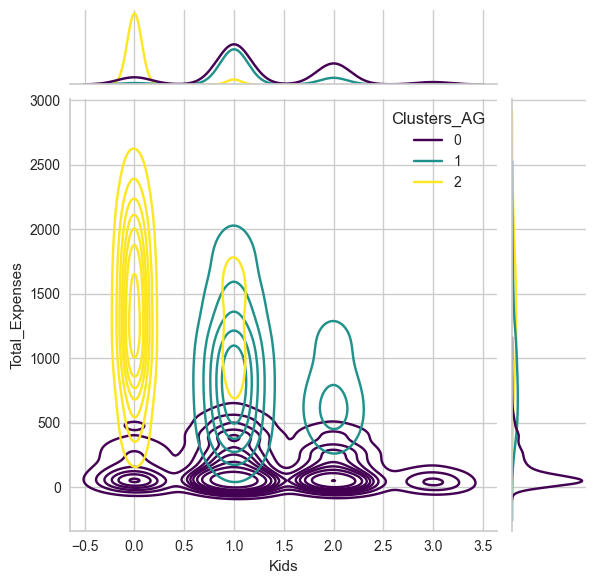

<Figure size 800x600 with 0 Axes>

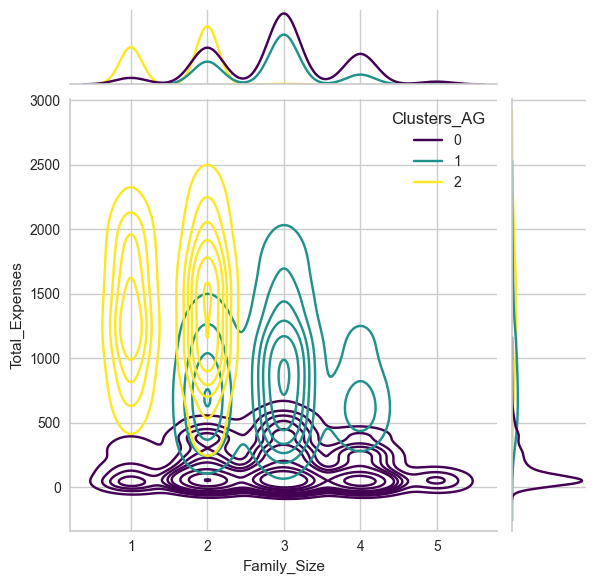

<Figure size 800x600 with 0 Axes>

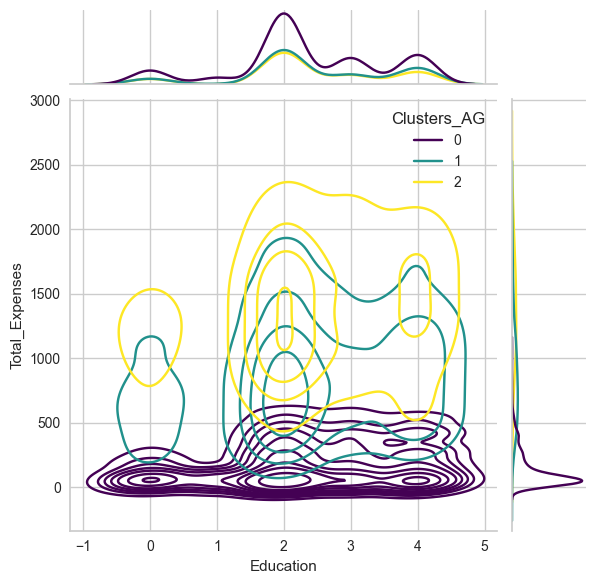

<Figure size 800x600 with 0 Axes>

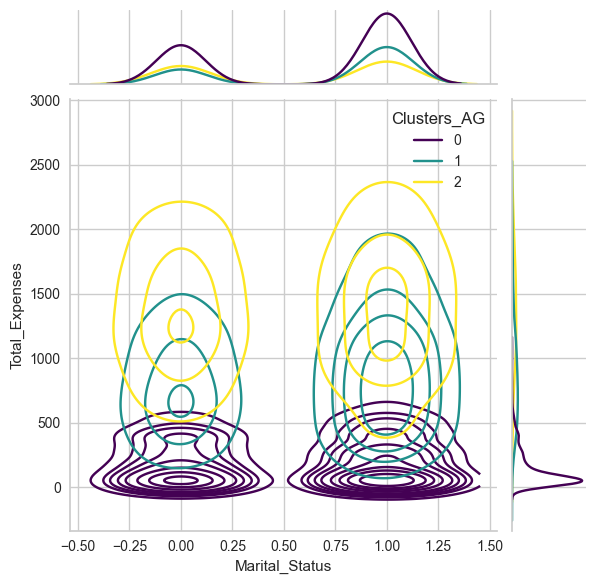

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

# List of variables for visualization
Personal = ["Kidhome", "Teenhome", "Age", "Kids", "Family_Size", "Education", "Marital_Status"]


pal = "viridis"  

# Loop through the columns and create the plots
for i in Personal:
    plt.figure(figsize=(8, 6))
    
    # Scatter Plot (instead of KDE)
    sns.jointplot(x=data[i], y=data["Total_Expenses"], hue=data["Clusters_AG"], kind="kde", palette=pal)
    plt.show()

   
    # sns.jointplot(x=data[i], y=data["Spent"], hue=data["Clusters"], kind="reg", palette=pal)  # Regression
    # sns.jointplot(x=data[i], y=data["Spent"], hue=data["Clusters"], kind="hex", palette=pal)  # Hexbin
    # sns.jointplot(x=data[i], y=data["Spent"], hue=data["Clusters"], kind="resid", palette=pal)  # Residuals


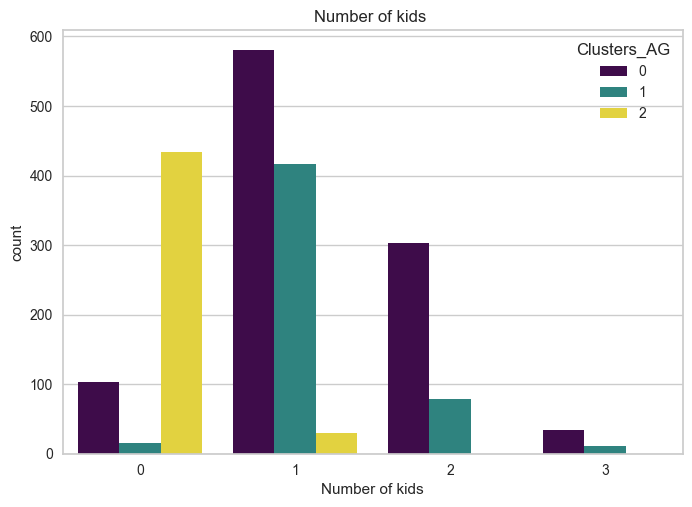

In [111]:
plt.figure()
pl = sns.countplot(x=data["Kids"],hue=data["Clusters_AG"], palette='viridis')
pl.set_title("Number of kids ")
pl.set_xlabel("Number of kids")
plt.show()

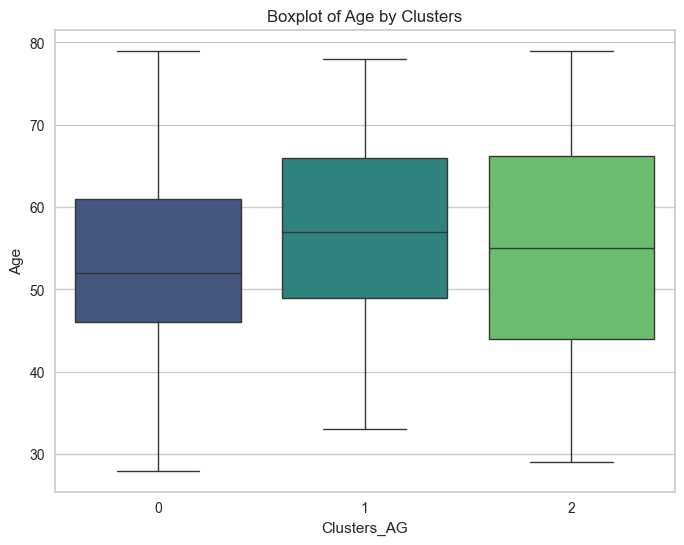

In [ ]:
#Deal purchase 
# Set the color palette for the boxplot
pal = "viridis" 
# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x="Clusters_AG", y="Age", data=data, palette=pal)

# Add a title to the plot
plt.title('Boxplot of Age by Clusters')

# Show the plot
plt.show()